In [1]:
import json
import pathlib
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

FILES = [
    "out/simulation_json/config_Zendure2400_noBattery.json",
    "out/simulation_json/config_Zendure2400_2880Wh.json",
    "out/simulation_json/config_Zendure2400_5760Wh.json",
    "out/simulation_json/config_Zendure2400_8640Wh.json",
    "out/simulation_json/config_Zendure2400_11520Wh.json",
    "out/simulation_json/config_Zendure2400_14400Wh.json",
]

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)
    
def battery_size_from_config(data) -> int:
    # total capacity across phases (Wh)
    return sum(data["configuration"]["battery"]["capacity_Wh_per_phase"])
EXPORT_FIGURES = True
MONTH_FIG_DIR = pathlib.Path("out/month_images")
MONTH_FIG_DIR.mkdir(parents=True, exist_ok=True)

FIG_EXPORT_COUNTER = 0

def export_current_figure(out_dir):
    global FIG_EXPORT_COUNTER
    if not EXPORT_FIGURES:
        return

    title = plt.gca().get_title() or "figure"
    slug = re.sub(r"[^a-z0-9]+", "_", title.lower()).strip("_")
    FIG_EXPORT_COUNTER += 1

    out_path = out_dir / f"{FIG_EXPORT_COUNTER:02d}_{slug}.png"
    plt.savefig(out_path, dpi=200)
    print(f"Saved figure: {out_path}")
SMOOTH_LINE_CHARTS = True

def _smooth_curve_xy_numeric(x, y, samples_per_segment=30):
    """Simple cubic Hermite interpolation (NumPy-only) for smoother line charts."""
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if x.size <= 2:
        return x, y

    order = np.argsort(x)
    x = x[order]
    y = y[order]

    unique_x, unique_idx = np.unique(x, return_index=True)
    x = unique_x
    y = y[unique_idx]
    if x.size <= 2:
        return x, y

    dx = np.diff(x)
    if np.any(dx <= 0):
        return x, y

    m = np.zeros_like(y)
    m[0] = (y[1] - y[0]) / (x[1] - x[0])
    m[-1] = (y[-1] - y[-2]) / (x[-1] - x[-2])
    for i in range(1, len(x) - 1):
        m[i] = (y[i + 1] - y[i - 1]) / (x[i + 1] - x[i - 1])

    xs_parts = []
    ys_parts = []
    nseg = len(x) - 1
    for i in range(nseg):
        x0, x1 = x[i], x[i + 1]
        y0, y1 = y[i], y[i + 1]
        h = x1 - x0
        if h <= 0:
            continue
        t = np.linspace(0.0, 1.0, samples_per_segment, endpoint=(i == nseg - 1))
        h00 = 2 * t**3 - 3 * t**2 + 1
        h10 = t**3 - 2 * t**2 + t
        h01 = -2 * t**3 + 3 * t**2
        h11 = t**3 - t**2
        xs = x0 + t * h
        ys = h00 * y0 + h10 * h * m[i] + h01 * y1 + h11 * h * m[i + 1]
        xs_parts.append(xs)
        ys_parts.append(ys)

    if not xs_parts:
        return x, y
    return np.concatenate(xs_parts), np.concatenate(ys_parts)

def plot_smooth_line(ax, x, y, *, marker="o", samples_per_segment=30, **kwargs):
    """Plot a smooth curve plus the original marker points (supports datetime or numeric x)."""
    x_series = pd.Series(list(x))
    y_series = pd.to_numeric(pd.Series(list(y)), errors="coerce")
    valid = x_series.notna() & y_series.notna()
    x_series = x_series[valid]
    y_vals = y_series[valid].to_numpy(dtype=float)

    if len(x_series) == 0:
        return []

    x_vals = x_series.to_list()

    if not SMOOTH_LINE_CHARTS or len(x_vals) <= 2:
        return ax.plot(x_vals, y_vals, marker=marker, **kwargs)

    x_dt = pd.to_datetime(x_series, errors="coerce")
    use_datetime = bool(x_dt.notna().all())
    if use_datetime:
        x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
    else:
        x_numeric = pd.to_numeric(x_series, errors="coerce").to_numpy(dtype=float)
        mask = np.isfinite(x_numeric)
        x_numeric = x_numeric[mask]
        y_vals = y_vals[mask]
        x_vals = [x_vals[i] for i, keep in enumerate(mask) if keep]
        if len(x_vals) == 0:
            return []

    plot_kwargs = dict(kwargs)
    linestyle = plot_kwargs.pop("linestyle", plot_kwargs.pop("ls", "-"))
    linewidth = plot_kwargs.pop("linewidth", plot_kwargs.pop("lw", 2))
    label = plot_kwargs.pop("label", None)
    color = plot_kwargs.pop("color", None)
    alpha = plot_kwargs.get("alpha", None)
    zorder = plot_kwargs.get("zorder", None)

    xs_num, ys = _smooth_curve_xy_numeric(x_numeric, y_vals, samples_per_segment=samples_per_segment)
    line_objs = ax.plot(
        xs_num if use_datetime else xs_num,
        ys,
        linestyle=linestyle,
        linewidth=linewidth,
        label=label,
        color=color,
        **plot_kwargs,
    )
    if use_datetime:
        ax.xaxis_date()
    line = line_objs[0]
    line_color = line.get_color()

    if marker:
        marker_kwargs = {
            "linestyle": "None",
            "marker": marker,
            "color": line_color,
            "label": "_nolegend_",
        }
        if alpha is not None:
            marker_kwargs["alpha"] = alpha
        if zorder is not None:
            marker_kwargs["zorder"] = zorder + 0.1 if isinstance(zorder, (int, float)) else zorder
        ax.plot(x_vals, y_vals, **marker_kwargs)

    return line_objs

def plot_smooth_pivot(pivot_df, *, ax=None, marker="o", linewidth=2, samples_per_segment=30):
    """Plot each pivot-table series as a smooth line with dot markers."""
    if ax is None:
        ax = plt.gca()
    color_cycle = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
    for i, col in enumerate(pivot_df.columns):
        series = pivot_df[col]
        color = color_cycle[i % len(color_cycle)] if color_cycle else None
        plot_smooth_line(
            ax,
            series.index,
            series.values,
            marker=marker,
            linewidth=linewidth,
            color=color,
            label=str(col),
            samples_per_segment=samples_per_segment,
        )
    return ax


Extract monthly data (cumulated phases)

In [2]:
MONTH_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    battery_size_wh = battery_size_from_config(data)

    months = data.get("months", [])
    if not months:
        print(f"⚠️ No months section in {scenario}, skipping")
        continue

    for m in months:
        month_range = m.get("range", {})

        is_full_month = month_range.get("is_full_month", False)
        n_days = month_range.get("calendar_duration_days", 0)

        # 🚫 skip incomplete / short months
        if not is_full_month and n_days < 28:
            continue

        month_id = m["range_id"]
        results = m["results"]

        # ---- cumulate energy across phases ----
        energy = results.get("energy", {})
        injected = energy.get("injected", [])
        consumed = energy.get("consumed", [])

        injected_kwh = sum(abs(e["energy_kwh"]) for e in injected)
        consumed_kwh = sum(abs(e["energy_kwh"]) for e in consumed)

        injected_chf = sum(e["delta_chf"] for e in injected)
        consumed_chf = sum(e["delta_chf"] for e in consumed)

        rentability = results.get("rentability", {})

        MONTH_ROWS.append({
            "month": month_id,
            "scenario": scenario,
            "battery_size_wh": battery_size_wh,

            "gain_chf": rentability.get("total_gain_chf", 0.0),

            "grid_consumed_kwh": consumed_kwh,
            "grid_injected_kwh": injected_kwh,

            "grid_consumed_chf": consumed_chf,
            "grid_injected_chf": injected_chf,
        })

df_monthly = pd.DataFrame(MONTH_ROWS)

df_monthly["month"] = pd.to_datetime(df_monthly["month"])
df_monthly = df_monthly.sort_values(["battery_size_wh", "month"])

scenario_order = (
    df_monthly[["scenario", "battery_size_wh"]]
    .drop_duplicates()
    .sort_values("battery_size_wh")["scenario"]
    .tolist()
)


Monthly gain (CHF) graph

Saved figure: out/month_images/01_monthly_net_financial_gain_vs_no_battery.png


/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

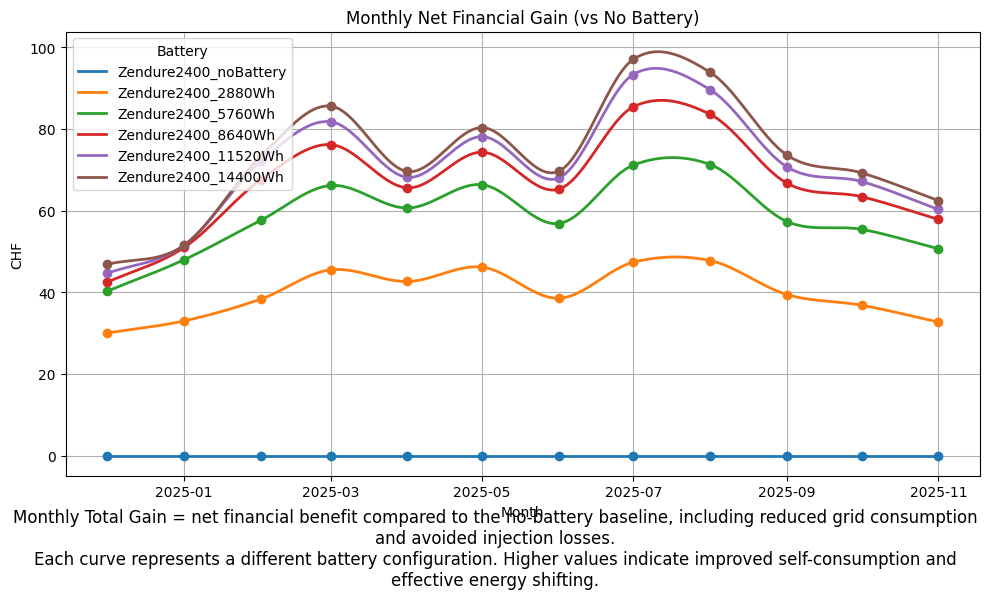

In [3]:
pivot_gain = df_monthly.pivot(
    index="month",
    columns="scenario",
    values="gain_chf"
)

pivot_gain = pivot_gain[scenario_order]

plot_smooth_pivot(pivot_gain, marker="o")
plt.title("Monthly Net Financial Gain (vs No Battery)")
plt.xlabel("Month")
plt.ylabel("CHF")
plt.legend(title="Battery")
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Monthly Total Gain = net financial benefit compared to the no-battery baseline, "
    "including reduced grid consumption and avoided injection losses.\n"
    "Each curve represents a different battery configuration. "
    "Higher values indicate improved self-consumption and effective energy shifting.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(MONTH_FIG_DIR)
plt.show()


/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

Saved figure: out/month_images/02_monthly_grid_import_reduction_vs_no_battery.png


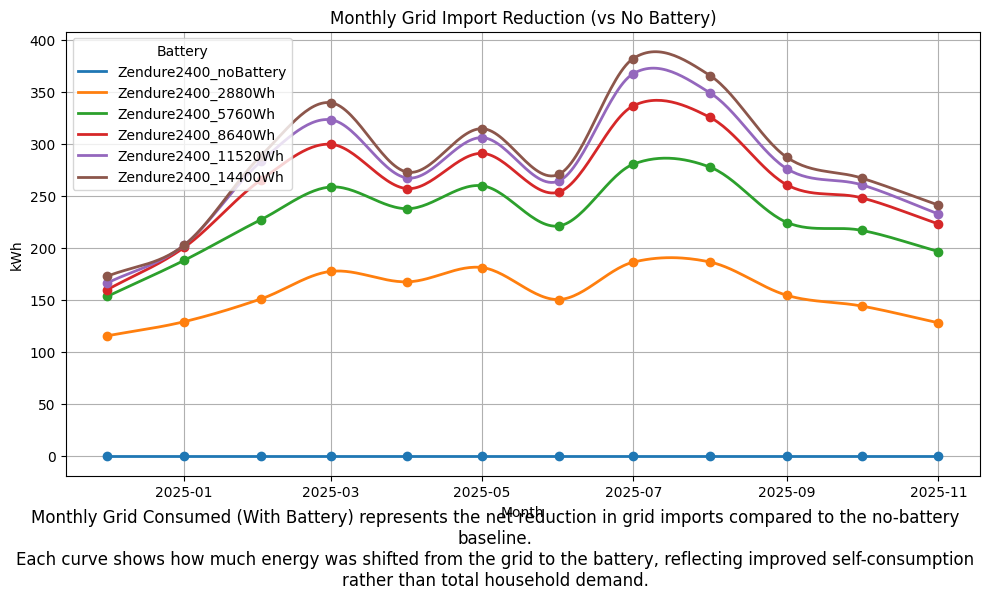

In [4]:
pivot_consumed = df_monthly.pivot(
    index="month",
    columns="scenario",
    values="grid_consumed_kwh"
)

pivot_consumed = pivot_consumed[scenario_order]

plot_smooth_pivot(pivot_consumed, marker="o")
plt.title("Monthly Grid Import Reduction (vs No Battery)")
plt.xlabel("Month")
plt.ylabel("kWh")
plt.legend(title="Battery")
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Monthly Grid Consumed (With Battery) represents the net reduction in grid imports "
    "compared to the no-battery baseline.\n"
    "Each curve shows how much energy was shifted from the grid to the battery, "
    "reflecting improved self-consumption rather than total household demand.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(MONTH_FIG_DIR)
plt.show()


/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

Saved figure: out/month_images/03_monthly_grid_export_reduction_vs_no_battery.png


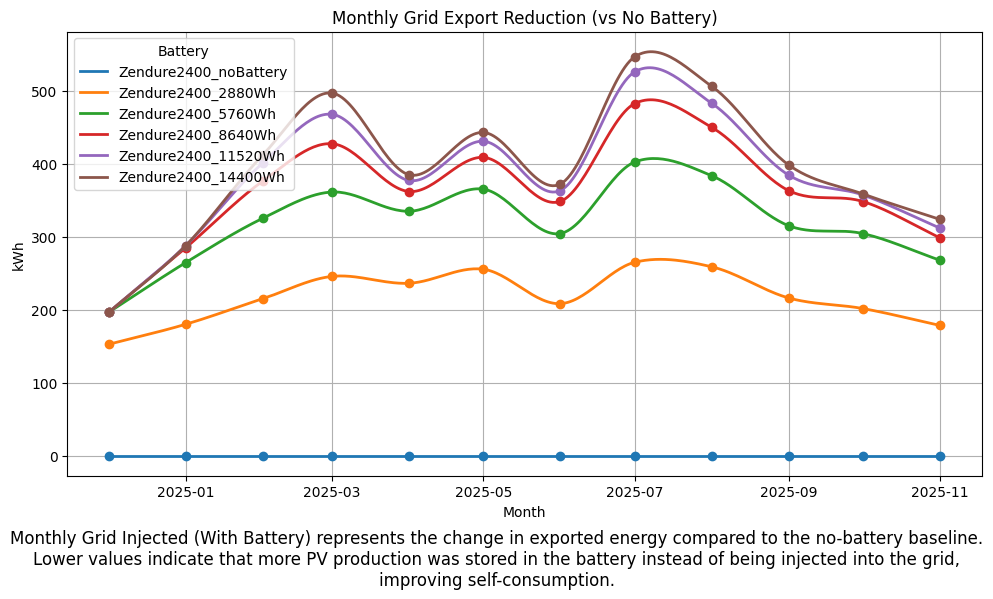

In [5]:
pivot_injected = df_monthly.pivot(
    index="month",
    columns="scenario",
    values="grid_injected_kwh"
)

pivot_injected = pivot_injected[scenario_order]

plot_smooth_pivot(pivot_injected, marker="o")
plt.title("Monthly Grid Export Reduction (vs No Battery)")
plt.xlabel("Month")
plt.ylabel("kWh")
plt.legend(title="Battery")
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Monthly Grid Injected (With Battery) represents the change in exported energy "
    "compared to the no-battery baseline.\n"
    "Lower values indicate that more PV production was stored in the battery "
    "instead of being injected into the grid, improving self-consumption.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(MONTH_FIG_DIR)
plt.show()


/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

Saved figure: out/month_images/04_monthly_energy_shifting_import_vs_export_reduction_vs_no_battery.png


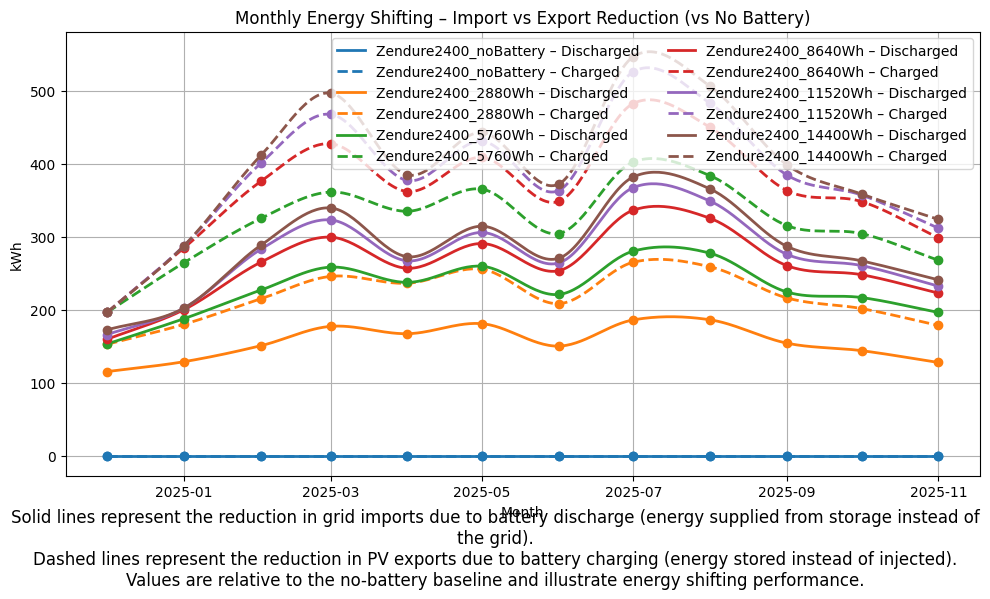

In [6]:
plt.figure(figsize=(10, 6))

color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i, scenario in enumerate(scenario_order):
    subset = (
        df_monthly[df_monthly["scenario"] == scenario]
        .sort_values("month")
    )

    color = color_cycle[i % len(color_cycle)]

    # Discharged effect (grid consumption reduction) – solid
    plot_smooth_line(plt.gca(),
        subset["month"],
        subset["grid_consumed_kwh"],
        marker="o",
        linestyle="-",
        color=color,
        label=f"{scenario} – Discharged"
    )

    # Charged effect (grid injection increase) – dashed
    plot_smooth_line(plt.gca(),
        subset["month"],
        subset["grid_injected_kwh"],
        marker="o",
        linestyle="--",
        color=color,
        label=f"{scenario} – Charged"
    )

plt.title("Monthly Energy Shifting – Import vs Export Reduction (vs No Battery)")
plt.xlabel("Month")
plt.ylabel("kWh")
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Solid lines represent the reduction in grid imports due to battery discharge "
    "(energy supplied from storage instead of the grid).\n"
    "Dashed lines represent the reduction in PV exports due to battery charging "
    "(energy stored instead of injected).\n"
    "Values are relative to the no-battery baseline and illustrate energy shifting performance.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(MONTH_FIG_DIR)
plt.show()


Saved figure: out/month_images/05_monthly_battery_energy_throughput_derived_from_grid_reduction.png


/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

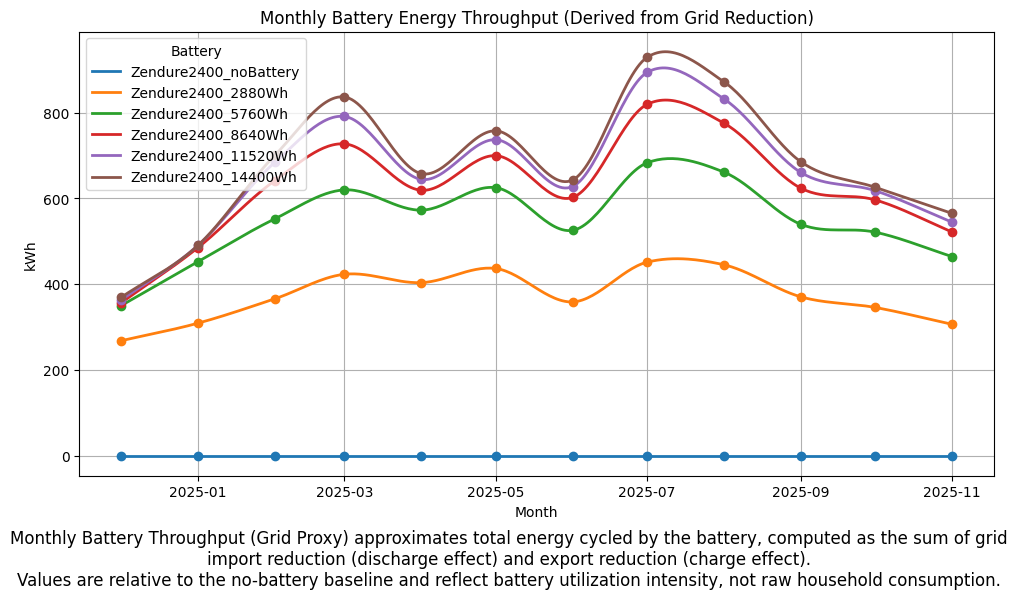

In [7]:
df_monthly["battery_throughput_kwh"] = (
    df_monthly["grid_consumed_kwh"] +
    df_monthly["grid_injected_kwh"]
)

pivot = df_monthly.pivot(
    index="month",
    columns="scenario",
    values="battery_throughput_kwh"
)

pivot = pivot[scenario_order]

plot_smooth_pivot(pivot, marker="o")
plt.title("Monthly Battery Energy Throughput (Derived from Grid Reduction)")
plt.xlabel("Month")
plt.ylabel("kWh")
plt.legend(title="Battery")
plt.grid(True)
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Monthly Battery Throughput (Grid Proxy) approximates total energy cycled by the battery, "
    "computed as the sum of grid import reduction (discharge effect) and export reduction "
    "(charge effect).\n"
    "Values are relative to the no-battery baseline and reflect battery utilization intensity, "
    "not raw household consumption.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(MONTH_FIG_DIR)
plt.show()


/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

Saved figure: out/month_images/06_monthly_equivalent_full_battery_cycles.png


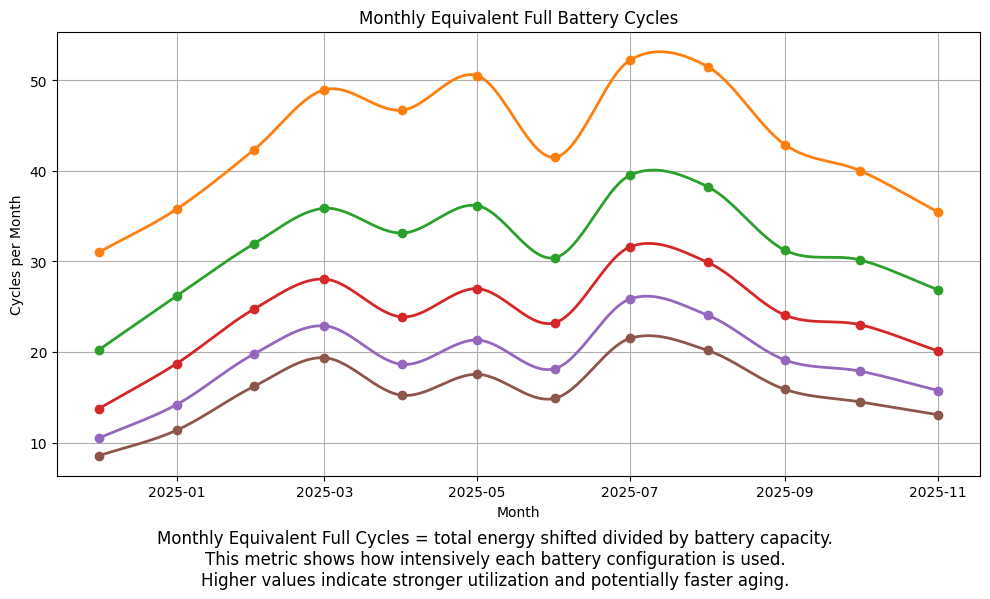

In [8]:
# Convert Wh → kWh
df_monthly["battery_size_kwh"] = df_monthly["battery_size_wh"] / 1000

# Monthly equivalent full cycles
df_monthly["monthly_cycles"] = (
    df_monthly["battery_throughput_kwh"] /
    df_monthly["battery_size_kwh"]
)

pivot_cycles = df_monthly.pivot(
    index="month",
    columns="scenario",
    values="monthly_cycles"
)

pivot_cycles = pivot_cycles[scenario_order]

plot_smooth_pivot(pivot_cycles, marker="o")

plt.title("Monthly Equivalent Full Battery Cycles")
plt.xlabel("Month")
plt.ylabel("Cycles per Month")
plt.grid(True)
plt.tight_layout(rect=[0, 0.10, 1, 1])

plt.figtext(
    0.5, 0.02,
    "Monthly Equivalent Full Cycles = total energy shifted divided by battery capacity.\n"
    "This metric shows how intensively each battery configuration is used.\n"
    "Higher values indicate stronger utilization and potentially faster aging.",
    ha="center",
    fontsize=12,
    wrap=True
)

export_current_figure(MONTH_FIG_DIR)
plt.show()


In [9]:
FULL_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    months = data.get("months", [])
    if not months:
        continue

    for m in months:
        month_range = m.get("range", {})

        is_full_month = month_range.get("is_full_month", False)
        n_days = month_range.get("calendar_duration_days", 0)

        if not is_full_month and n_days < 28:
            continue

        month_id = m["range_id"]
        status = m["results"].get("battery", {}).get("status", {})

        full_samples = 0
        total_samples = status.get("samples_analyzed", 0)

        if total_samples == 0:
            continue

        for phase in ["A", "B", "C"]:
            full_samples += (
                status.get(phase, {})
                .get("full", {})
                .get("sample_count", 0)
            )

        FULL_ROWS.append({
            "month": month_id,
            "scenario": scenario,
            "avg_full_pct": 100.0 * full_samples / total_samples
        })

df_monthly_full = pd.DataFrame(FULL_ROWS)
df_monthly_full["month"] = pd.to_datetime(df_monthly_full["month"])


/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

Saved figure: out/month_images/07_monthly_energy_saturation_battery_full_soc_100.png


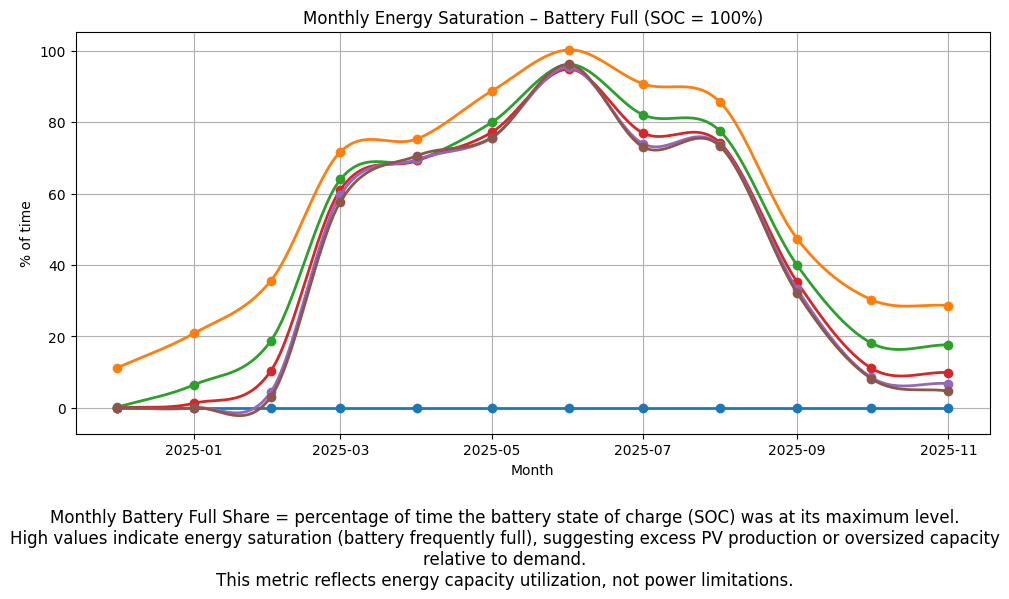

In [10]:
pivot = df_monthly_full.pivot(
    index="month",
    columns="scenario",
    values="avg_full_pct"
)

pivot = pivot[scenario_order]

plot_smooth_pivot(pivot, marker="o")
plt.title("Monthly Energy Saturation – Battery Full (SOC = 100%)")
plt.xlabel("Month")
plt.ylabel("% of time")
plt.grid(True)
plt.tight_layout(rect=[0, 0.17, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Monthly Battery Full Share = percentage of time the battery state of charge (SOC) "
    "was at its maximum level.\n"
    "High values indicate energy saturation (battery frequently full), suggesting "
    "excess PV production or oversized capacity relative to demand.\n"
    "This metric reflects energy capacity utilization, not power limitations.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(MONTH_FIG_DIR)
plt.show()


In [11]:
EMPTY_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    months = data.get("months", [])
    if not months:
        continue

    for m in months:
        r = m.get("range", {})
        if not r.get("is_full_month", False) and r.get("calendar_duration_days", 0) < 28:
            continue

        month_id = m["range_id"]
        status = m["results"].get("battery", {}).get("status", {})

        total_samples = status.get("samples_analyzed", 0)
        if total_samples == 0:
            continue

        empty_samples = sum(
            status.get(phase, {})
                  .get("empty", {})
                  .get("sample_count", 0)
            for phase in ["A", "B", "C"]
        )

        # Average across phases (not sum)
        avg_empty_pct = 100.0 * (empty_samples / 3.0) / total_samples

        EMPTY_ROWS.append({
            "month": month_id,
            "scenario": scenario,
            "avg_empty_pct": avg_empty_pct
        })

df_monthly_empty = pd.DataFrame(EMPTY_ROWS)
df_monthly_empty["month"] = pd.to_datetime(df_monthly_empty["month"])


/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

Saved figure: out/month_images/08_monthly_energy_limitation_battery_empty_soc_0.png


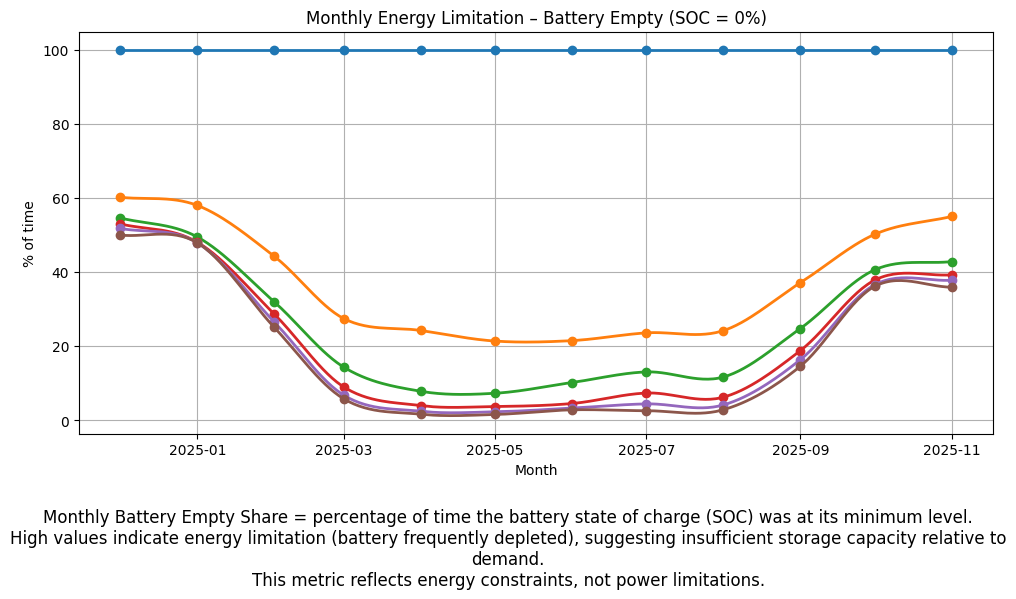

In [12]:
pivot = df_monthly_empty.pivot(
    index="month",
    columns="scenario",
    values="avg_empty_pct"
)

pivot = pivot[scenario_order]

plot_smooth_pivot(pivot, marker="o")
plt.title("Monthly Energy Limitation – Battery Empty (SOC = 0%)")
plt.xlabel("Month")
plt.ylabel("% of time")
plt.grid(True)
plt.tight_layout(rect=[0, 0.17, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Monthly Battery Empty Share = percentage of time the battery state of charge (SOC) "
    "was at its minimum level.\n"
    "High values indicate energy limitation (battery frequently depleted), suggesting "
    "insufficient storage capacity relative to demand.\n"
    "This metric reflects energy constraints, not power limitations.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(MONTH_FIG_DIR)
plt.show()


In [13]:
UNDERSIZE_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    months = data.get("months", [])
    if not months:
        continue

    for m in months:
        r = m.get("range", {})

        is_full_month = r.get("is_full_month", False)
        n_days = r.get("calendar_duration_days", 0)

        if not is_full_month and n_days < 28:
            continue

        month_id = m["range_id"]

        battery_block = m.get("results", {}).get("battery", {})

        energy_undersize = battery_block.get("energy_undersize_days", {})
        evening_undersize = battery_block.get("evening_undersize_days", {})

        UNDERSIZE_ROWS.append({
            "month": month_id,
            "scenario": scenario,
            "energy_undersize_pct": energy_undersize.get("percent", 0.0),
            "evening_undersize_pct": evening_undersize.get("percent", 0.0)
        })

df_monthly_undersize = pd.DataFrame(UNDERSIZE_ROWS)

if not df_monthly_undersize.empty:
    df_monthly_undersize["month"] = pd.to_datetime(df_monthly_undersize["month"])


/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

Saved figure: out/month_images/09_monthly_structural_energy_undersizing_daily_level.png


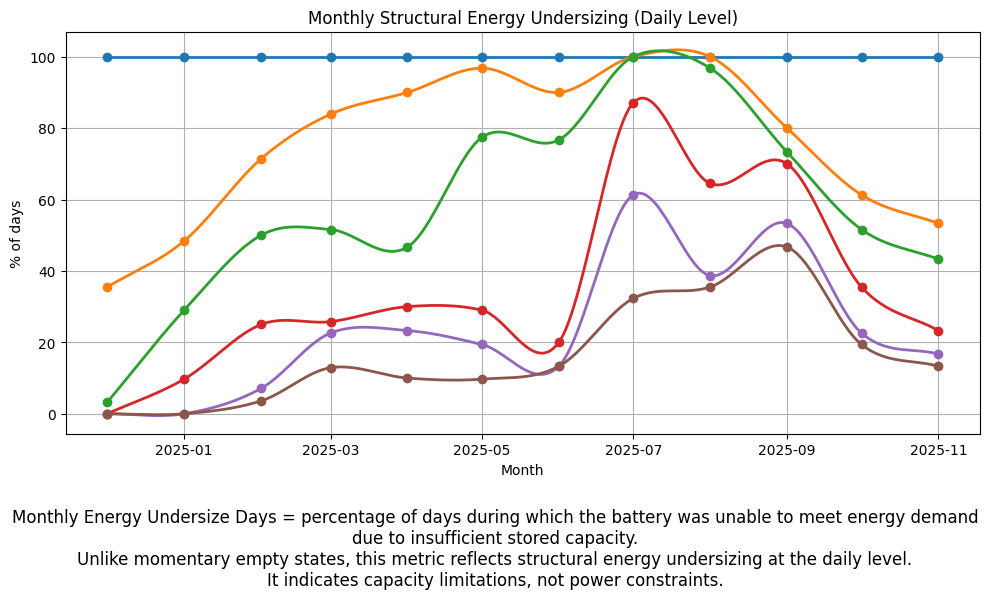

In [14]:
pivot = df_monthly_undersize.pivot(
    index="month",
    columns="scenario",
    values="energy_undersize_pct"
)

pivot = pivot[scenario_order]

plot_smooth_pivot(pivot, marker="o")
plt.title("Monthly Structural Energy Undersizing (Daily Level)")
plt.xlabel("Month")
plt.ylabel("% of days")
plt.grid(True)
plt.tight_layout(rect=[0, 0.17, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Monthly Energy Undersize Days = percentage of days during which the battery "
    "was unable to meet energy demand due to insufficient stored capacity.\n"
    "Unlike momentary empty states, this metric reflects structural energy undersizing "
    "at the daily level.\n"
    "It indicates capacity limitations, not power constraints.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(MONTH_FIG_DIR)
plt.show()


/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

Saved figure: out/month_images/10_monthly_structural_evening_energy_undersizing_peak_period.png


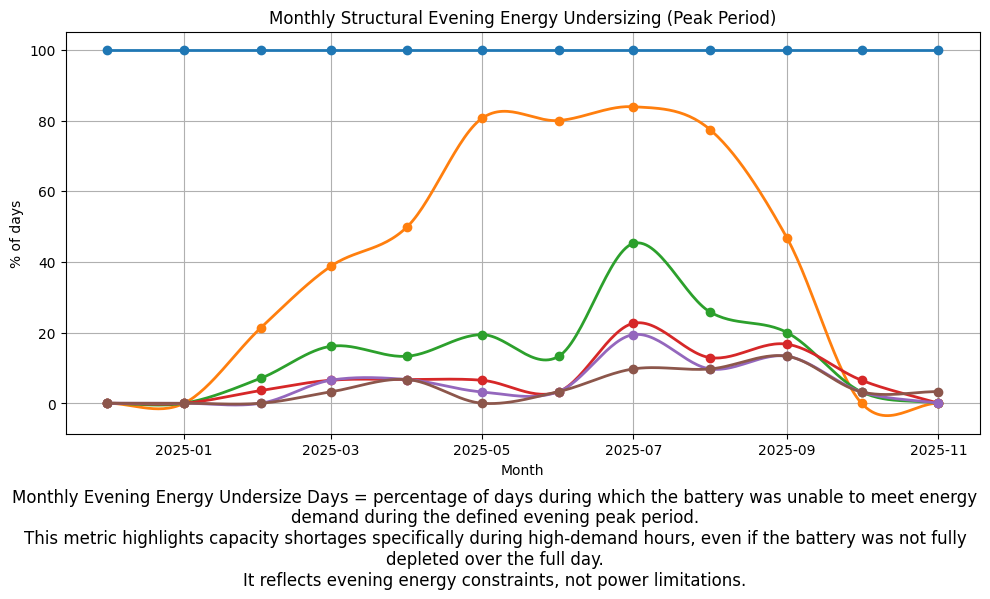

In [15]:
pivot_evening = df_monthly_undersize.pivot(
    index="month",
    columns="scenario",
    values="evening_undersize_pct"
)

pivot_evening = pivot_evening[scenario_order]

plot_smooth_pivot(pivot_evening, marker="o")

plt.title("Monthly Structural Evening Energy Undersizing (Peak Period)")
plt.xlabel("Month")
plt.ylabel("% of days")
plt.grid(True)
plt.tight_layout(rect=[0, 0.17, 1, 1])

plt.figtext(
    0.5, 0.02,
    "Monthly Evening Energy Undersize Days = percentage of days during which the battery "
    "was unable to meet energy demand during the defined evening peak period.\n"
    "This metric highlights capacity shortages specifically during high-demand hours, "
    "even if the battery was not fully depleted over the full day.\n"
    "It reflects evening energy constraints, not power limitations.",
    ha="center",
    fontsize=12,
    wrap=True
)

export_current_figure(MONTH_FIG_DIR)
plt.show()


In [16]:
ACTIVE_POWER_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    months = data.get("months", [])
    if not months:
        continue

    for m in months:
        r = m.get("range", {})
        if not r.get("is_full_month", False) and r.get("calendar_duration_days", 0) < 28:
            continue

        pu = m["results"].get("battery", {}).get("power_usage", {})
        total_samples = pu.get("samples_analyzed", 0)
        if total_samples == 0:
            continue

        active_at_max_samples = (
            sum(
                pu.get("charging", {})
                  .get(p, {})
                  .get("at_max", {})
                  .get("sample_count", 0)
                for p in ["A", "B", "C"]
            )
            +
            sum(
                pu.get("discharging", {})
                  .get(p, {})
                  .get("at_max", {})
                  .get("sample_count", 0)
                for p in ["A", "B", "C"]
            )
        )

        ACTIVE_POWER_ROWS.append({
            "month": m["range_id"],
            "scenario": scenario,
            "active_power_at_max_pct": 100.0 * active_at_max_samples / total_samples
        })

df_monthly_active_power_sat = pd.DataFrame(ACTIVE_POWER_ROWS)
df_monthly_active_power_sat["month"] = pd.to_datetime(df_monthly_active_power_sat["month"])


/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

Saved figure: out/month_images/11_monthly_power_saturation_active_charge_discharge.png


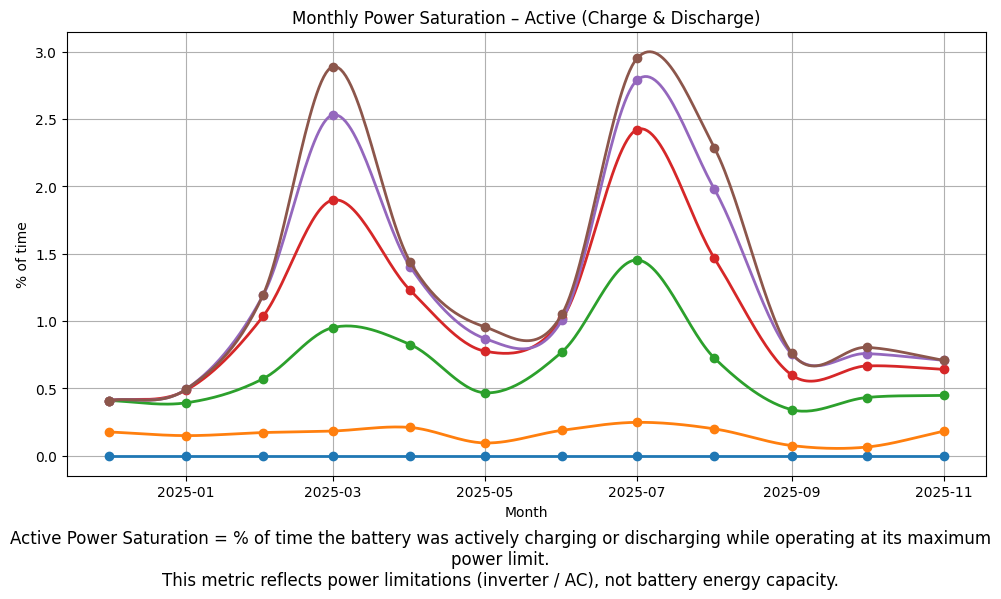

In [17]:
pivot = df_monthly_active_power_sat.pivot(
    index="month",
    columns="scenario",
    values="active_power_at_max_pct"
)

pivot = pivot[scenario_order]

plot_smooth_pivot(pivot, marker="o")
plt.title("Monthly Power Saturation – Active (Charge & Discharge)")
plt.xlabel("Month")
plt.ylabel("% of time")
plt.grid(True)
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Active Power Saturation = % of time the battery was actively charging or discharging "
    "while operating at its maximum power limit.\n"
    "This metric reflects power limitations (inverter / AC), not battery energy capacity.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(MONTH_FIG_DIR)
plt.show()


In [18]:
IDLE_POWER_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    months = data.get("months", [])
    if not months:
        continue

    for m in months:
        r = m.get("range", {})
        if not r.get("is_full_month", False) and r.get("calendar_duration_days", 0) < 28:
            continue

        pu = m["results"].get("battery", {}).get("power_usage", {})
        total_samples = pu.get("samples_analyzed", 0)
        if total_samples == 0:
            continue

        idle_power_limited_samples = (
            sum(
                pu.get("idle", {})
                  .get(p, {})
                  .get("could_charge_at_max", {})
                  .get("sample_count", 0)
                for p in ["A", "B", "C"]
            )
            +
            sum(
                pu.get("idle", {})
                  .get(p, {})
                  .get("could_discharge_at_max", {})
                  .get("sample_count", 0)
                for p in ["A", "B", "C"]
            )
        )

        IDLE_POWER_ROWS.append({
            "month": m["range_id"],
            "scenario": scenario,
            "idle_power_limited_pct": 100.0 * idle_power_limited_samples / total_samples
        })

df_monthly_idle_power_limited = pd.DataFrame(IDLE_POWER_ROWS)
df_monthly_idle_power_limited["month"] = pd.to_datetime(df_monthly_idle_power_limited["month"])


/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

Saved figure: out/month_images/12_monthly_power_saturation_idle_missed_opportunities.png


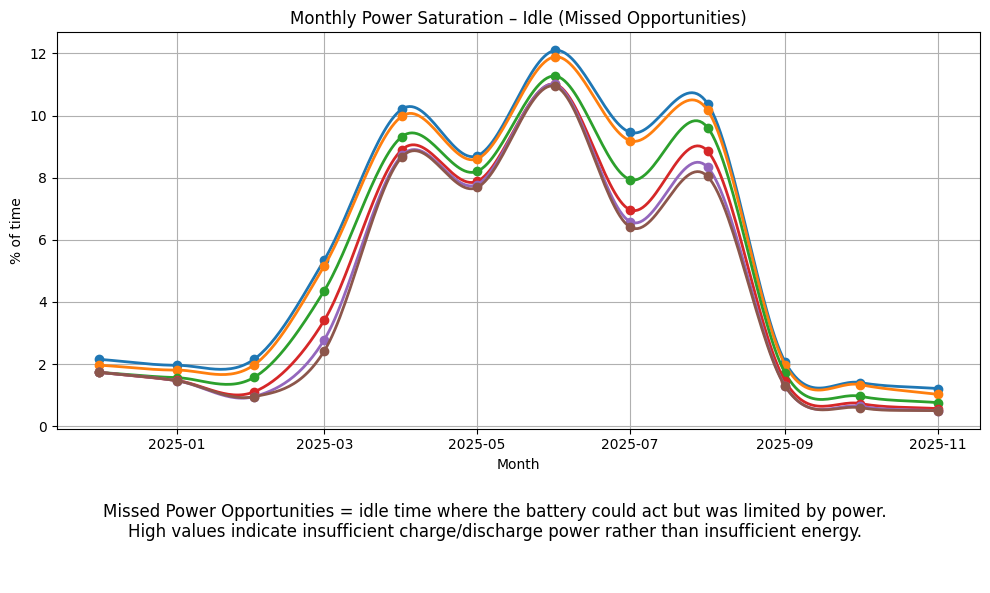

In [19]:
pivot = df_monthly_idle_power_limited.pivot(
    index="month",
    columns="scenario",
    values="idle_power_limited_pct"
)

pivot = pivot[scenario_order]

plot_smooth_pivot(pivot, marker="o")
plt.title("Monthly Power Saturation – Idle (Missed Opportunities)")
plt.xlabel("Month")
plt.ylabel("% of time")
plt.grid(True)
plt.tight_layout(rect=[0, 0.18, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Missed Power Opportunities = idle time where the battery could act but was limited by power.\n"
    "High values indicate insufficient charge/discharge power rather than insufficient energy.\n\n",
    ha="center",
    va="bottom",
    fontsize=12,
    wrap=True
)
export_current_figure(MONTH_FIG_DIR)
plt.show()


In [20]:
POWER_STACK_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    months = data.get("months", [])
    if not months:
        continue

    for m in months:
        r = m.get("range", {})
        if not r.get("is_full_month", False) and r.get("calendar_duration_days", 0) < 28:
            continue

        pu = m["results"].get("battery", {}).get("power_usage", {})
        total_samples = pu.get("samples_analyzed", 0)
        if total_samples == 0:
            continue

        def sum_samples(mode, phase_key):
            return sum(
                pu.get(mode, {})
                .get(p, {})
                .get(phase_key, {})
                .get("sample_count", 0)
                for p in ["A", "B", "C"]
            )

        POWER_STACK_ROWS.append({
            "month": m["range_id"],
            "scenario": scenario,

            "charging_at_max_pct": 100 * sum_samples("charging", "at_max") / total_samples,
            "charging_not_at_max_pct": 100 * sum_samples("charging", "not_at_max") / total_samples,

            "discharging_at_max_pct": 100 * sum_samples("discharging", "at_max") / total_samples,
            "discharging_not_at_max_pct": 100 * sum_samples("discharging", "not_at_max") / total_samples,

            "idle_could_charge_at_max_pct": 100 * sum_samples("idle", "could_charge_at_max") / total_samples,
            "idle_could_charge_not_at_max_pct": 100 * sum_samples("idle", "could_charge_not_at_max") / total_samples,

            "idle_could_discharge_at_max_pct": 100 * sum_samples("idle", "could_discharge_at_max") / total_samples,
            "idle_could_discharge_not_at_max_pct": 100 * sum_samples("idle", "could_discharge_not_at_max") / total_samples,

        })

df_monthly_power_stack = pd.DataFrame(POWER_STACK_ROWS)
df_monthly_power_stack["month"] = pd.to_datetime(df_monthly_power_stack["month"])


Saved figure: out/month_images/13_monthly_power_state_distribution_active_idle.png


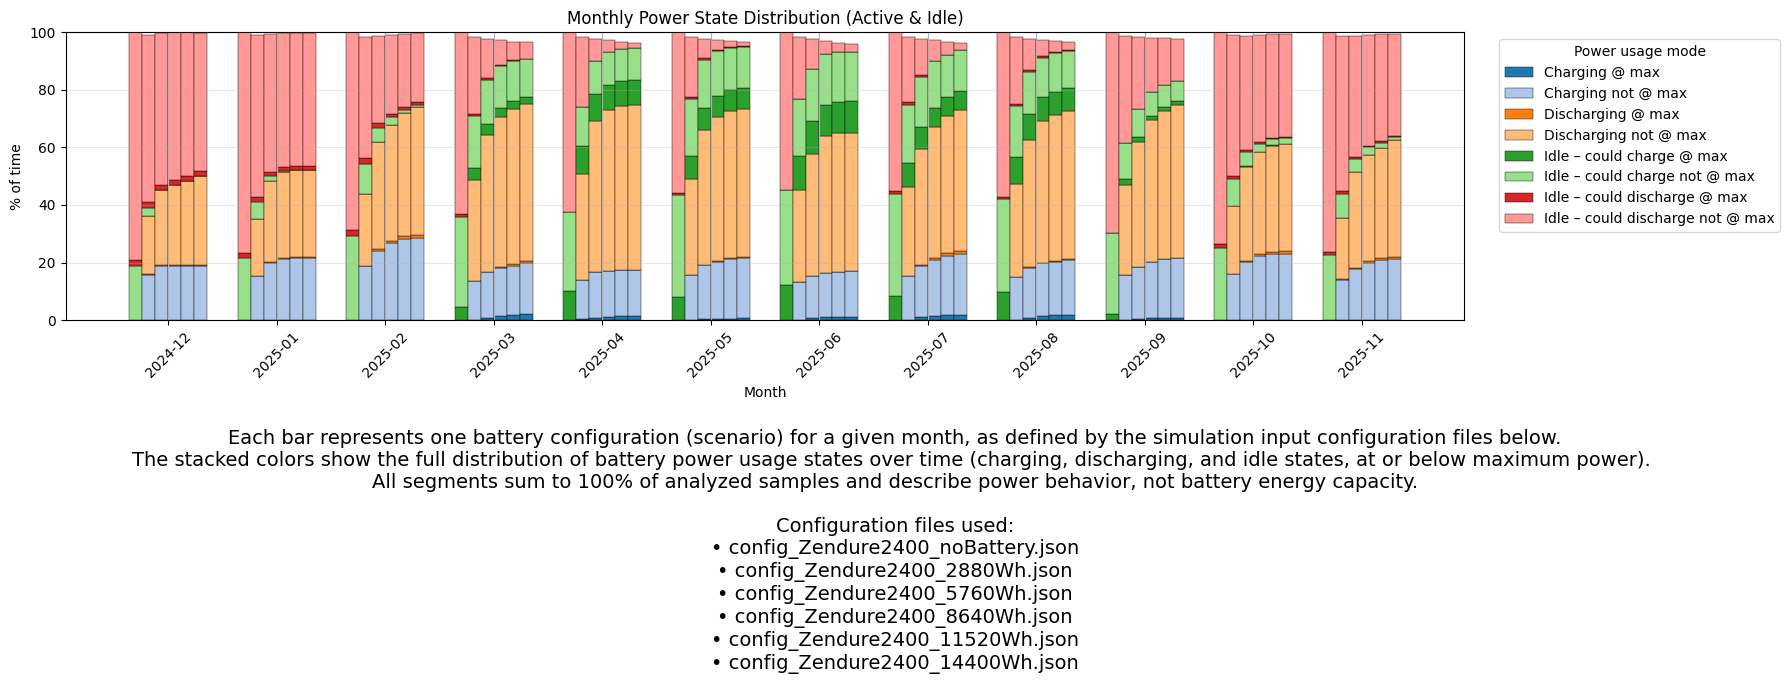

In [21]:
STACK_COMPONENTS = [
    # Charging
    ("charging_at_max_pct", "Charging @ max", "#1f77b4"),
    ("charging_not_at_max_pct", "Charging not @ max", "#aec7e8"),

    # Discharging
    ("discharging_at_max_pct", "Discharging @ max", "#ff7f0e"),
    ("discharging_not_at_max_pct", "Discharging not @ max", "#ffbb78"),

    # Idle – could charge
    ("idle_could_charge_at_max_pct", "Idle – could charge @ max", "#2ca02c"),
    ("idle_could_charge_not_at_max_pct", "Idle – could charge not @ max", "#98df8a"),

    # Idle – could discharge
    ("idle_could_discharge_at_max_pct", "Idle – could discharge @ max", "#d62728"),
    ("idle_could_discharge_not_at_max_pct", "Idle – could discharge not @ max", "#ff9896"),
]

months = sorted(df_monthly_power_stack["month"].unique())
x = np.arange(len(months))
bar_width = 0.12

plt.figure(figsize=(18, 7))

for b_idx, scenario in enumerate(scenario_order):
    subset = (
        df_monthly_power_stack[df_monthly_power_stack["scenario"] == scenario]
        .set_index("month")
        .reindex(months)
    )

    bottom = np.zeros(len(months))
    x_pos = x + b_idx * bar_width

    for col, label, color in STACK_COMPONENTS:
        if col not in subset:
            continue

        values = subset[col].values
        plt.bar(
            x_pos,
            values,
            width=bar_width,
            bottom=bottom,
            color=color,
            edgecolor="black",
            linewidth=0.3,
            label=label if b_idx == 0 else None
        )
        bottom += values

plt.xticks(
    x + bar_width * (len(scenario_order) - 1) / 2,
    [m.strftime("%Y-%m") for m in months],
    rotation=45
)

plt.xlabel("Month")
plt.ylabel("% of time")
plt.ylim(0, 100) 
plt.title("Monthly Power State Distribution (Active & Idle)")
plt.legend(
    title="Power usage mode",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)
config_list = "\n".join(
    f"• {pathlib.Path(f).name}" for f in FILES
)

plt.figtext(
    0.5, 0.03,
    "Each bar represents one battery configuration (scenario) for a given month, "
    "as defined by the simulation input configuration files below.\n"
    "The stacked colors show the full distribution of battery power usage states over time "
    "(charging, discharging, and idle states, at or below maximum power). \n"
    "All segments sum to 100% of analyzed samples and describe power behavior, "
    "not battery energy capacity.\n\n"
    f"Configuration files used:\n{config_list}",
    ha="center",
    va="bottom",
    fontsize=14,
    wrap=True
)

plt.grid(axis="y", alpha=0.3)
plt.tight_layout(rect=[0, 0.40, 1, 1])
export_current_figure(MONTH_FIG_DIR)
plt.show()


In [22]:
SAMPLE_DURATION_H = 1  # 1 hour per sample

CHARGE_DISCHARGE_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    for m in data.get("months", []):
        r = m.get("range", {})
        if not r.get("is_full_month", False) and r.get("calendar_duration_days", 0) < 28:
            continue

        month_id = m["range_id"]
        pu = m.get("results", {}).get("battery", {}).get("power_usage", {})

        charging_samples = 0
        discharging_samples = 0

        for phase in ["A", "B", "C"]:

            # Charging
            charging_samples += (
                pu.get("charging", {})
                  .get(phase, {})
                  .get("at_max", {})
                  .get("sample_count", 0)
            )

            charging_samples += (
                pu.get("charging", {})
                  .get(phase, {})
                  .get("not_at_max", {})
                  .get("sample_count", 0)
            )

            # Discharging
            discharging_samples += (
                pu.get("discharging", {})
                  .get(phase, {})
                  .get("at_max", {})
                  .get("sample_count", 0)
            )

            discharging_samples += (
                pu.get("discharging", {})
                  .get(phase, {})
                  .get("not_at_max", {})
                  .get("sample_count", 0)
            )

        CHARGE_DISCHARGE_ROWS.append({
            "month": month_id,
            "scenario": scenario,
            "charging_hours": charging_samples * SAMPLE_DURATION_H,
            "discharging_hours": discharging_samples * SAMPLE_DURATION_H
        })

df_monthly_activity = pd.DataFrame(CHARGE_DISCHARGE_ROWS)
df_monthly_activity["month"] = pd.to_datetime(df_monthly_activity["month"])


Saved figure: out/month_images/14_monthly_battery_activity_duration_charging_vs_discharging.png


/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_numeric = mdates.date2num(x_dt.dt.to_pydatetime())
/var/folders/yr/09j4jf5s71ddlp_x_drwf04m0000gn/T/ipykernel_46559/3431443389.py:117: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

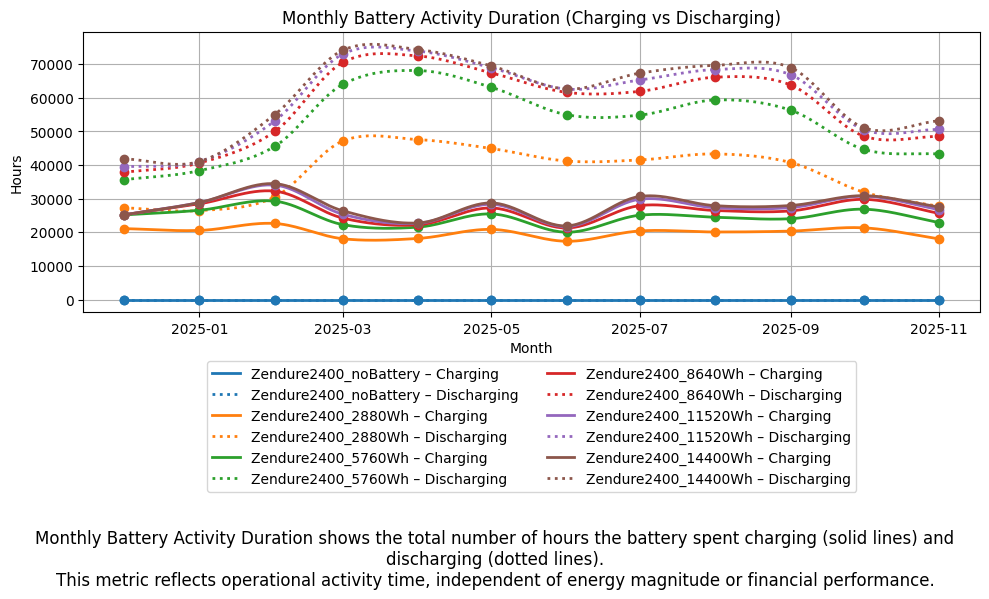

In [23]:
plt.figure(figsize=(10, 6))

color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i, scenario in enumerate(scenario_order):
    subset = (
        df_monthly_activity[df_monthly_activity["scenario"] == scenario]
        .sort_values("month")
    )

    color = color_cycle[i % len(color_cycle)]

    # Charging – solid line
    plot_smooth_line(plt.gca(),
        subset["month"],
        subset["charging_hours"],
        marker="o",
        linestyle="-",
        color=color,
        label=f"{scenario} – Charging"
    )

    # Discharging – dotted line
    plot_smooth_line(plt.gca(),
        subset["month"],
        subset["discharging_hours"],
        marker="o",
        linestyle=":",
        color=color,
        label=f"{scenario} – Discharging"
    )

plt.title("Monthly Battery Activity Duration (Charging vs Discharging)")
plt.xlabel("Month")
plt.ylabel("Hours")

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2
)
plt.tight_layout(rect=[0, 0.10, 1, 1])

plt.grid(True)

plt.figtext(
    0.5, 0.02,
    "Monthly Battery Activity Duration shows the total number of hours the battery "
    "spent charging (solid lines) and discharging (dotted lines).\n"
    "This metric reflects operational activity time, independent of energy magnitude "
    "or financial performance.",
    ha="center",
    fontsize=12,
    wrap=True
)

export_current_figure(MONTH_FIG_DIR)
plt.show()
